In [122]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import chi2
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from collections import Counter
from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.interpolate import interp1d
from sklearn.utils import resample
import math
from scipy.stats import wilcoxon
from skbio.stats.composition import clr
from scipy.spatial.distance import pdist, squareform

## Load and explore the Metagenomics Data

In [125]:
#Read the file 
meta_genom= pd.read_csv("Metagenomics dataset (species).csv")

In [127]:
meta_genom.shape

(60, 107)

In [129]:
meta_genom.head()

,Sample_ID,Patient,Timepoint,Lachnospiraceae_unclassified,Bacteroides,Prevotella,Phocaeicola,Ruminococcus,Roseburia,Alistipes,...,Clostridia_unclassified,Eggerthella,Enterobacter,Citrobacter,GGB4769,GGB9818,GGB9063,Kluyvera,Phascolarctobacterium,Duodenibacillus
0,1A,1,Baseline,2.92958,5.78386,0.00000,5.00265,2.77255,1.41996,20.90402,...,0.04649,0.09125,0.01343,0.00000,0.70877,0.00000,0.00278,0.0,0.00149,0.0
1,2A,2,Baseline,2.41025,27.35725,0.00000,40.01393,0.03560,0.99051,0.45567,...,0.03018,0.03440,0.02602,11.67937,0.00000,0.00000,0.00000,0.0,0.00000,0.0
2,3A,3,Baseline,1.66037,23.01123,0.00000,19.37158,2.97402,4.88987,1.40536,...,0.14074,0.00000,0.00000,0.00000,0.00000,0.07099,0.00000,0.0,1.48351,0.0
3,4A,4,Baseline,1.66635,10.20774,16.31878,11.81602,3.39577,3.20409,1.59004,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.0
4,5A,5,Baseline,4.62832,10.02323,0.00000,11.75125,2.00029,1.79542,0.95784,...,0.00000,0.00000,0.00000,0.00000,0.00458,0.00000,0.02278,0.0,0.02577,0.0


In [131]:
# Remove low expressed taxa 

meta_genom = meta_genom.loc[:, (meta_genom == 0). mean(axis =0) < 0.8]

In [133]:
#Remove missing values 
meta_genom = meta_genom.dropna()

In [135]:
meta_genom.shape

(60, 57)

In [137]:
#Filter Data according to timepoints

# Filter only Baseline and Week 4 samples
filtered_b2 = meta_genom[meta_genom['Timepoint'].isin(['Baseline', 'Week 2'])]
filtered_b4 = meta_genom[meta_genom['Timepoint'].isin(['Baseline', 'Week 4'])]
filtered_b8 = meta_genom[meta_genom['Timepoint'].isin(['Baseline', 'Week 8'])]
# Display the result
filtered_b8.head(30)

,Sample_ID,Patient,Timepoint,Lachnospiraceae_unclassified,Bacteroides,Prevotella,Phocaeicola,Ruminococcus,Roseburia,Alistipes,...,Enterocloster,Lachnoclostridium,Erysipelatoclostridium,Pediococcus,Granulicatella,Haemophilus,Ligilactobacillus,Clostridia_unclassified,Enterobacter,Citrobacter
0,1A,1,Baseline,2.92958,5.78386,0.00000,5.00265,2.77255,1.41996,20.90402,...,0.56572,0.16825,0.16162,0.00000,0.00000,0.00000,0.00000,0.04649,0.01343,0.00000
1,2A,2,Baseline,2.41025,27.35725,0.00000,40.01393,0.03560,0.99051,0.45567,...,0.89794,0.55239,0.07893,0.00000,0.00000,0.00000,0.00000,0.03018,0.02602,11.67937
2,3A,3,Baseline,1.66037,23.01123,0.00000,19.37158,2.97402,4.88987,1.40536,...,0.00000,0.00173,0.00000,0.00000,0.00000,0.00347,0.00000,0.14074,0.00000,0.00000
3,4A,4,Baseline,1.66635,10.20774,16.31878,11.81602,3.39577,3.20409,1.59004,...,0.00000,0.01125,0.00000,0.00000,0.00000,0.00181,0.00000,0.00000,0.00000,0.00000
4,5A,5,Baseline,4.62832,10.02323,0.00000,11.75125,2.00029,1.79542,0.95784,...,0.20962,0.07149,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,6A,6,Baseline,0.91891,35.40248,0.00000,13.41448,0.00000,0.00000,0.00000,...,0.83869,0.00000,1.18574,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,7A,7,Baseline,0.28132,2.89196,58.59810,3.14961,0.14234,10.47382,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00495,1.36345,0.00000,0.00000,0.00000,0.00000
7,8A,8,Baseline,16.69097,9.78011,8.14592,6.83967,6.75162,5.47213,4.06935,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,9A,9,Baseline,2.78095,14.74323,0.00000,20.30169,0.08659,1.42500,0.00000,...,0.10085,0.05320,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,10A,10,Baseline,13.15177,15.41382,0.00043,12.06950,0.93081,4.84578,1.21045,...,0.00000,0.00000,0.00000,0.00000,0.00232,2.42768,0.00000,0.00000,0.00000,0.00000


In [139]:
# Seperate meta data from metatranscriptomic

#baseline vs week 2
y_2 = filtered_b2["Timepoint"]
x_2 = filtered_b2.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

#baseline vs week 4 
y_4 = filtered_b4["Timepoint"]
x_4 = filtered_b4.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

#baseline vs week 8

y_8 = filtered_b8["Timepoint"]
x_8 = filtered_b8.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

#all 

y = meta_trans['Timepoint']
x = meta_trans.drop(columns= ["Patient", "Timepoint", "Sample_ID"])

## Preprocssing 

In [142]:
# Add Pseduo-count to avoid zeros 
df_pesudo_2 = x_2 + 1e-5
df_pesudo_4 = x_4 + 1e-5
df_pesudo_8 = x_8 + 1e-5

In [144]:
# Apply clr 
df_clr_2 = pd.DataFrame(clr(df_pesudo_2.values), index=x_2.index, columns=x_2.columns)
df_clr_4 = pd.DataFrame(clr(df_pesudo_4.values), index=x_4.index, columns=x_4.columns)
df_clr_8 = pd.DataFrame(clr(df_pesudo_8.values), index=x_8.index, columns=x_8.columns)

In [150]:
# Apply Standard Scaler

scaler = StandardScaler()
df_scaled_2 = pd.DataFrame(scaler.fit_transform(df_clr_2), index=x_2.index, columns=x_2.columns)
df_scaled_4 = pd.DataFrame(scaler.fit_transform(df_clr_4), index=x_4.index, columns=x_4.columns)
df_scaled_8 = pd.DataFrame(scaler.fit_transform(df_clr_8), index=x_8.index, columns=x_8.columns)

In [152]:
# Bray-Curtis distance matrix 

dist_matrix_2 = squareform(pdist(df_scaled_2, metric='braycurtis'))
dist_matrix_4 = squareform(pdist(df_scaled_4, metric='braycurtis'))
dist_matrix_8 = squareform(pdist(df_scaled_8, metric='braycurtis'))

In [154]:
# confidence_ellipse function (slightly modified to allow fill)
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', edgecolor='black', **kwargs):
    if x.size <= 2 or np.all(x == x[0]) or np.all(y == y[0]):
        return
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse((mean_x, mean_y), width, height, angle=theta,
                      facecolor=facecolor, edgecolor=edgecolor, **kwargs)
    ax.add_patch(ellipse)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


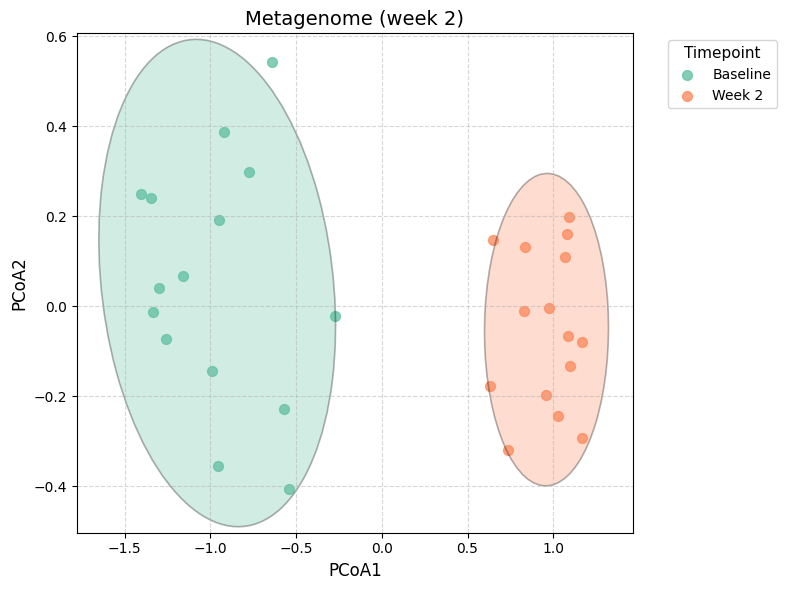

In [164]:
# Step 5: PCoA (using classical MDS)
pcoa = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_coords = pcoa.fit_transform(dist_matrix_2)  # dist_matrix: your precomputed distance matrix

# Create DataFrame for PCoA results
pcoa_df = pd.DataFrame(pcoa_coords, columns=["PCoA1", "PCoA2"], index=filtered_b2.index)
pcoa_df['Sample_ID'] = pcoa_df.index  # optional if Sample_ID is part of index

# Merge with metadata
plot_df = pcoa_df.merge(filtered_b2, left_index=True, right_index=True)

# Step 6: Plot and detect outliers
# Define custom group colors
colors = {
    'Baseline': '#66c2a5',
    'Week 2': '#fc8d62'
}

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

for group in plot_df["Timepoint"].unique():
    group_data = plot_df[plot_df["Timepoint"] == group]
    
    ax.scatter(
        group_data["PCoA1"], group_data["PCoA2"],
        label=group, s=50, alpha=0.8, color=colors.get(group, 'gray')
    )

    # Draw confidence ellipse for each group
    confidence_ellipse(
        group_data["PCoA1"].values,
        group_data["PCoA2"].values,
        ax,
        n_std=2.0,
        facecolor=colors.get(group, 'gray'),
        edgecolor='black',
        linewidth=1.2,
        alpha=0.3
    )

# Labels and styling
ax.set_title("Metagenome (week 2)", fontsize=14)
ax.set_xlabel("PCoA1", fontsize=12)
ax.set_ylabel("PCoA2", fontsize=12)
ax.tick_params(labelsize=10)
ax.legend(title="Timepoint", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, title_fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('PCoA_metagenome_week2.png', dpi=300)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


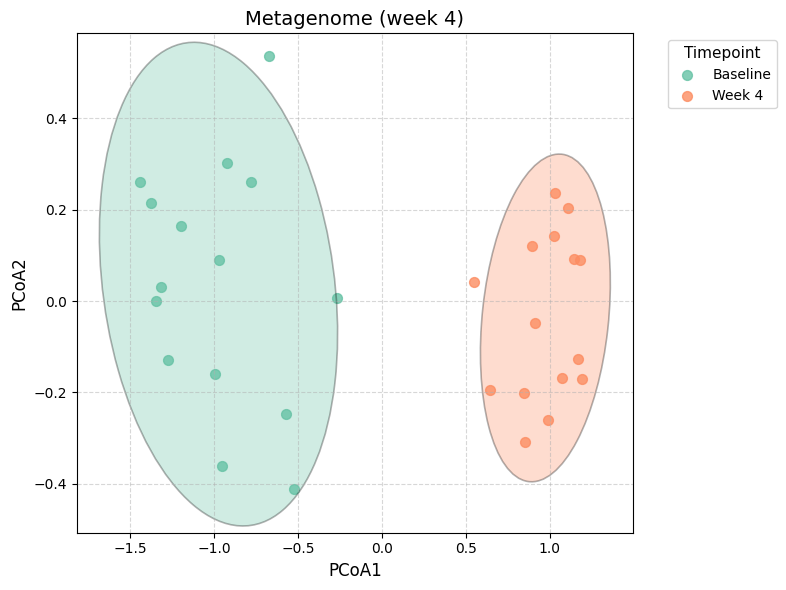

In [166]:
# Step 5: PCoA (using classical MDS)
pcoa = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_coords = pcoa.fit_transform(dist_matrix_4)  # dist_matrix: your precomputed distance matrix

# Create DataFrame for PCoA results
pcoa_df = pd.DataFrame(pcoa_coords, columns=["PCoA1", "PCoA2"], index=filtered_b4.index)
pcoa_df['Sample_ID'] = pcoa_df.index  # optional if Sample_ID is part of index

# Merge with metadata
plot_df = pcoa_df.merge(filtered_b4, left_index=True, right_index=True)

# Step 6: Plot and detect outliers
# Define custom group colors
colors = {
    'Baseline': '#66c2a5',
    'Week 4': '#fc8d62'
}

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

for group in plot_df["Timepoint"].unique():
    group_data = plot_df[plot_df["Timepoint"] == group]
    
    ax.scatter(
        group_data["PCoA1"], group_data["PCoA2"],
        label=group, s=50, alpha=0.8, color=colors.get(group, 'gray')
    )

    # Draw confidence ellipse for each group
    confidence_ellipse(
        group_data["PCoA1"].values,
        group_data["PCoA2"].values,
        ax,
        n_std=2.0,
        facecolor=colors.get(group, 'gray'),
        edgecolor='black',
        linewidth=1.2,
        alpha=0.3
    )

# Labels and styling
ax.set_title("Metagenome (week 4)", fontsize=14)
ax.set_xlabel("PCoA1", fontsize=12)
ax.set_ylabel("PCoA2", fontsize=12)
ax.tick_params(labelsize=10)
ax.legend(title="Timepoint", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, title_fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('PCoA_metagenome_week4.png', dpi=300)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


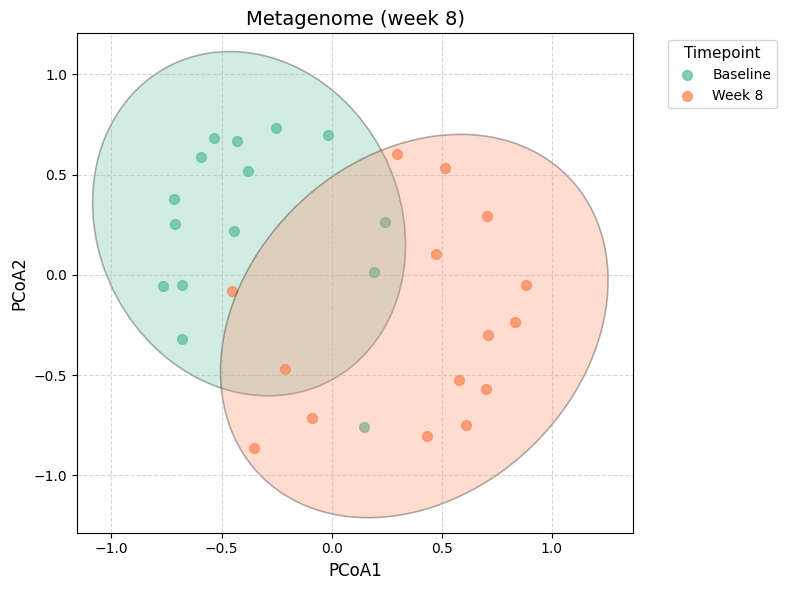

In [168]:
# Step 5: PCoA (using classical MDS)
pcoa = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_coords = pcoa.fit_transform(dist_matrix_8)  # dist_matrix: your precomputed distance matrix

# Create DataFrame for PCoA results
pcoa_df = pd.DataFrame(pcoa_coords, columns=["PCoA1", "PCoA2"], index=filtered_b8.index)
pcoa_df['Sample_ID'] = pcoa_df.index  # optional if Sample_ID is part of index

# Merge with metadata
plot_df = pcoa_df.merge(filtered_b8, left_index=True, right_index=True)

# Step 6: Plot and detect outliers
# Define custom group colors
colors = {
    'Baseline': '#66c2a5',
    'Week 8': '#fc8d62'
}

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

for group in plot_df["Timepoint"].unique():
    group_data = plot_df[plot_df["Timepoint"] == group]
    
    ax.scatter(
        group_data["PCoA1"], group_data["PCoA2"],
        label=group, s=50, alpha=0.8, color=colors.get(group, 'gray')
    )

    # Draw confidence ellipse for each group
    confidence_ellipse(
        group_data["PCoA1"].values,
        group_data["PCoA2"].values,
        ax,
        n_std=2.0,
        facecolor=colors.get(group, 'gray'),
        edgecolor='black',
        linewidth=1.2,
        alpha=0.3
    )

# Labels and styling
ax.set_title("Metagenome (week 8)", fontsize=14)
ax.set_xlabel("PCoA1", fontsize=12)
ax.set_ylabel("PCoA2", fontsize=12)
ax.tick_params(labelsize=10)
ax.legend(title="Timepoint", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, title_fontsize=11)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('PCoA_metagenome_week8.png', dpi=300)
plt.show()